### Visualización y Modelo de NLP

En este notebook utilizaremos el conjunto que hemos inspeccionado y adecuado para crear unas sencillas representaciones de los datos  y poder realizar un sencillo modelo que nos ayude a analizar los sentimientos descritos en las diferentes reseñas. Así, el siguiente script está dividido en los siguientes bloques:

- **BLOQUE A**: carga de datos inspeccionados.
- **BLOQUE B**: visualización. 
- **BLOQUE C**: preprocesamiento del texto.
- **BLOQUE D**: partición del conjunto de datos en train y test.
- **BLOQUE E**: vectorización  del texto.
- **BLOQUE F**: entrenamiento de distintos modelos.
- **BLOQUE G**: inferencia sobre los datos de test.
- **BLOQUE H**: exportación de uno de los modelos.

In [2]:
import pandas as pd
import re
import pickle
import joblib
import random

import seaborn as sns
import matplotlib.pyplot as plt 

from wordcloud import WordCloud
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report


In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vincenzo.germinara/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/vincenzo.germinara/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### BLOQUE A: Carga de datos
Antes de comenzar, cargaremos los datos que han sido adecuados en nuestra fase anterior de limpieza y preprocesamiento de textos

In [45]:
# Carga de datos ya adecuados
df = pd.read_csv('../data/amazon_reviews_clean.csv')

In [46]:
# ¿Que dimensiones tiene el conjunto de datos?
df.shape

(3620, 3)

In [47]:
# Mostramos las primeras observaciones del conjunto
df.head()

,sentiment,text,length
0,1,Initial charge took about 3 hours. Batteries a...,513
1,1,"I kept looking at my watch. I kept thinking, ""...",390
2,1,I've used this battery backup for less then a ...,374
3,1,This flag is very cheap in construction. Flag ...,193
4,1,But I thought it was the whole season of Ponde...,151


### BLOQUE B: visualización

En este bloque utilizaremos las librerias [matplotlib](https://matplotlib.org/) y [seaborn](https://seaborn.pydata.org/) para crear unas sencillas representaciones de los datos a modo general y descriptivo, mientras que  nos ayudaremos de la librería [wordcloud](https://amueller.github.io/word_cloud/) para poder crear visualizaciones acerca de los textos que vamos a analizar.

/tmp/ipykernel_10221/3564934854.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', palette='viridis', data=df)


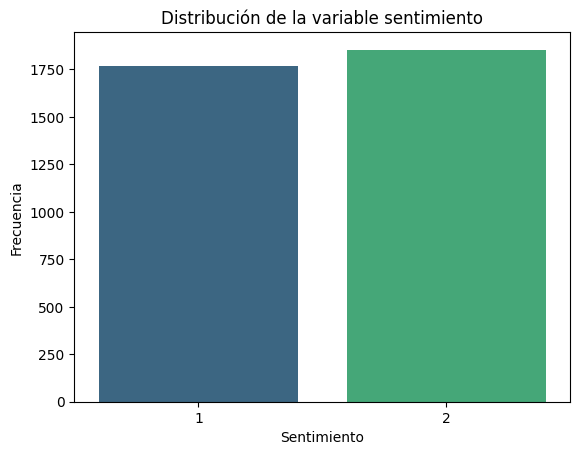

In [48]:
# Gráfico de barras para la variable sentiment
sns.countplot(x='sentiment', palette='viridis', data=df)
plt.title('Distribución de la variable sentimiento')
plt.ylabel('Frecuencia')
plt.xlabel('Sentimiento')
plt.show()

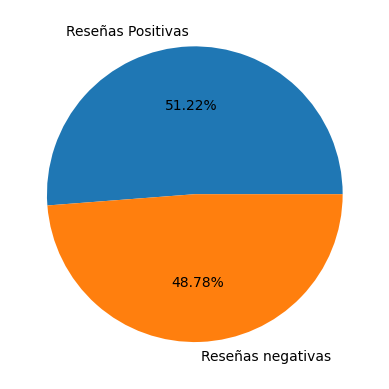

In [49]:
# Gráfico 'pie' con porcentajes para la variable objetivo sentiment
plt.pie(df['sentiment'].value_counts(), autopct="%.2f%%", labels=['Reseñas Positivas', 'Reseñas negativas'])
plt.show()

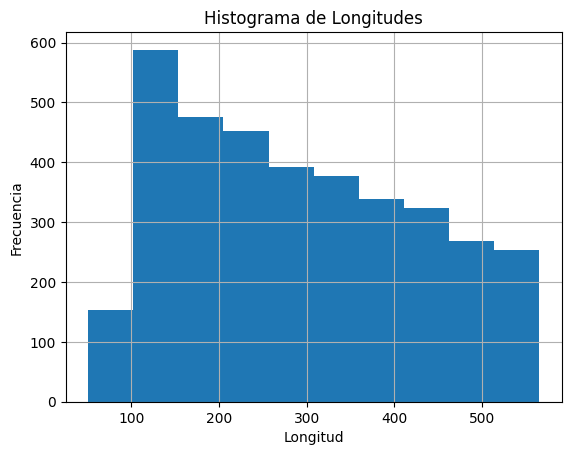

In [50]:
# Histograma de la distribución de las logitudes de las reselas.
# Utilizamos los histogramas proporcionados por el propio dataframe.
df['length'].hist()
plt.title('Histograma de Longitudes')
plt.xlabel('Longitud')
plt.ylabel('Frecuencia')
plt.show()

/tmp/ipykernel_10221/4025227170.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sentiment', y='length', data=df, palette='Set2')


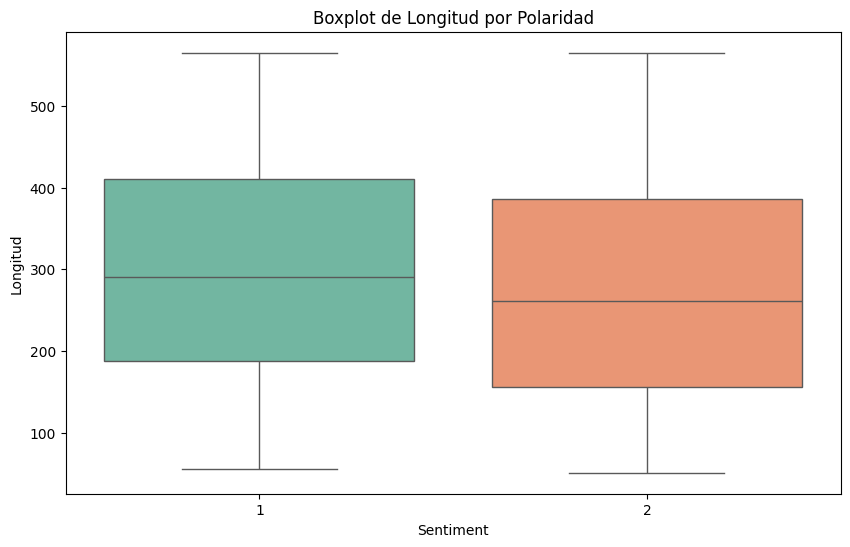

In [51]:
# Distribución de la Longitud por cada tipo de sentimiento
plt.figure(figsize=(10, 6))

sns.boxplot(x='sentiment', y='length', data=df, palette='Set2')

plt.title('Boxplot de Longitud por Polaridad')
plt.xlabel('Sentiment')
plt.ylabel('Longitud')
plt.show()

Vamos a crear un gráfico de las palabras más comunes en las reseñas de cada tipo de sentimiento

In [52]:
# Filtramos el conjunto de datos para quedarnos para quedarnos solo con reseñas positivas
positivedata = df.loc[df['sentiment']==2, 'text']

# Hacemos lo mismo esta vez con los reseñas negativas
negdata = df.loc[df['sentiment']==1, 'text']

In [53]:
# Función para poder realizar el gráfico
def wordcloud_draw(data, color, title):
    words = ' '.join(data)
    wordcloud = WordCloud(stopwords=stopwords.words('english'),
                          background_color=color,
                          width=2500,height=2000).generate(words)
    plt.imshow(wordcloud)
    plt.title(title)
    plt.axis('off')

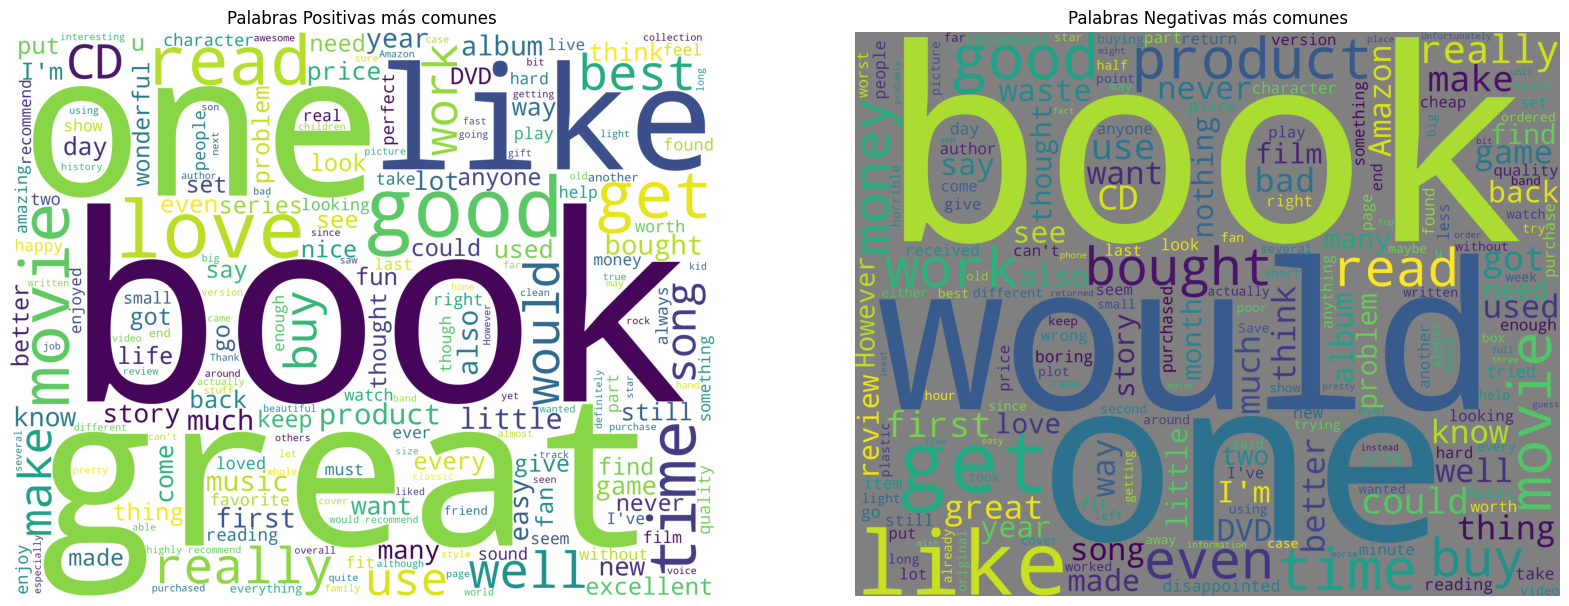

In [54]:
# Representamos los dos gráficos en una sola visualización
plt.figure(figsize=[20,10])
plt.subplot(1,2,1)
wordcloud_draw(positivedata,'white','Palabras Positivas más comunes')

plt.subplot(1,2,2)
wordcloud_draw(negdata, 'grey','Palabras Negativas más comunes')
plt.show()

### BLOQUE C: Preprocesamiento del texto

El preprocesamiento del texto es una fase importante dentro del Procesamiento del Lenguaje Natural (NLP). El objetivo de esta fase es la de transformar el texto en crudo, de manera que sea más fácilmente consumible por los algoritmos y modelos de Machine Learning (ML) y Deep Learning (DL) a aplicar.

Esta fase consta de diferentes pasos y no son siempre los mismos. En este caso, preprocesaremos las reseñas de la siguiente manera:

1. **Lower Casing**: Transformar palabras de mayúsculas a minúsculas.

2. **Eliminar Non-Alphabets**: Reemplazar todos los caracteres excepto alphabets por un espacio.

3. **Eliminar letras consecutivas**: 3 o más letras consecutivas son reemplazadas por 2 letras (ejemplo: "Heyyyy" por "Heyy").

4. **Tokenizacíon**:  proceso de dividir un texto en unidades más pequeñas llamadas tokens (palabras).

5. **Eliminar Stopwords**: Las Stopwords son aquellas palabras en ingés que no tienen un significado específico por si solas, por lo que pueden ser ignoradas sin sacrificar el significado de la oración (ejemplos: "the", "a").

6. **Eliminar palabras cortas**: Palabras con menos de 2 letras son eliminadas.




In [55]:
# Función para preprocesar el texto en crudo
def preprocess(text):    

    # Definir patrones para reemplazar/eliminar.
    alphaPattern      = "[^a-zA-Z]"
    sequencePattern   = r"(.)\1\1\1*"
    seqReplacePattern = r"\1\1"    

    
    # Crear lista de stopwords
    en_stop =  set(stopwords.words('english')) - {'not','no'}  # set(['a', 'an', 'the', 'in', 'does', 'do'])

    # Lower Casing
    text = text.lower()

    # Reemplazar non-alphabets.
    text = re.sub(alphaPattern, " ", text)

     # Reemplazar letras consecutivas.
    text = re.sub(sequencePattern, seqReplacePattern, text)
    
    # Tokenizar texto
    tokens = word_tokenize(text)

    # Eliminar stopwords
    tokens = [word for word in tokens if word not in en_stop]
    
    # Eliminar stringas con menos de dos elementos
    tokens = [word for word in tokens if len(word)>2]
    
        
    return tokens

In [56]:
# Aplicamos la función a cada una de las reseñas
df['preprocess_text'] = df['text'].apply(preprocess)

In [57]:
# Resultados del preprocesamiento: un ejemplo
print('Texto en crudo:', df.loc[1, 'text'])
print('Texto preprocesado:', df.loc[1, 'preprocess_text'])

Texto en crudo: I kept looking at my watch. I kept thinking, "this seems like a good time for the movie to end." But it didn't. Like the Energizer Bunny, it kept on and on. I tried to like it, really I did, but I found it to be pretentious fluff, lengthy at that. It simply took too long to get to whatever was supposed to be the point. As I left the theatre, I just knew the critics were going to love it.
Texto preprocesado: ['kept', 'looking', 'watch', 'kept', 'thinking', 'seems', 'like', 'good', 'time', 'movie', 'end', 'like', 'energizer', 'bunny', 'kept', 'tried', 'like', 'really', 'found', 'pretentious', 'fluff', 'lengthy', 'simply', 'took', 'long', 'get', 'whatever', 'supposed', 'point', 'left', 'theatre', 'knew', 'critics', 'going', 'love']


### BLOQUE D: Partición del conjunto de datos en train y test (80,20)

In [58]:
X = df['preprocess_text']
y = df['sentiment']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [59]:
# Información acerca de los conjuntos
print('Tamaño del conjunto de entrenamiento:', len(X_train))
print('Tamaño del conjunto de test:', len(X_test))

Tamaño del conjunto de entrenamiento: 2896
Tamaño del conjunto de test: 724


In [60]:
# Frequencias relativas de 'Sentiment' en el conjunto de intrenamiento
round(y_train.value_counts(normalize=True), 2)

2    0.52
1    0.48
Name: sentiment, dtype: float64

In [61]:
# Frequencias relativas de 'Sentiment' en el conjunto de test
round(y_test.value_counts(normalize=True), 2)

1    0.52
2    0.48
Name: sentiment, dtype: float64

### BLOQUE E: Vectorización del texto

Antes de dar el texto en input a un modelo es necesario vectorizarlo: convertir las palabras en números.

La conversión del texto en una representación númerica es uno de los pasos más importantes dentro de cualquier *pipeline* de NLP. Esta conversión resulta esencial para que las "máquinas" puedan comprender y decodificar patrones dentro de cualquier lenguaje.

Se trata de un proceso iterativo y que puede ser realizado mediante múltiples maneras o técnicas, abarcando desde las representaciones más sencillas (por ejemlo, One hot encoding) hasta otras más "inteligentes", que logran tener en cuenta las similitudes y diferencias entre ellas al basar su aprendizaje en redes neuronales (Word embeddings).

En este caso vamos a utilizar la técnica TF-IDF (Term Frequency-Inverse Document Frequency). A continuación, se describen los conceptos clave:

1. Term Frequency (TF):
Mide la frecuencia de un término específico en un documento.
Se calcula dividiendo el número de veces que un término aparece en un documento entre el número total de términos en el documento.
Cuanto más frecuente es un término en un documento, mayor es su valor de TF.

2. Inverse Document Frequency (IDF):
Mide la importancia de un término en el conjunto de documentos.
Se calcula tomando el logaritmo del inverso de la proporción de documentos que contienen el término.
Términos que aparecen en muchos documentos tendrán un IDF más bajo, ya que se consideran menos informativos.
3. TF-IDF:
Combina TF y IDF para asignar un peso a cada término en cada documento. \
**TF-IDF = TF * IDF** \
Los términos que son frecuentes en un documento pero raros en el conjunto de documentos tendrán un alto valor de TF-IDF, lo que indica su importancia relativa en ese documento específico.

In [62]:
# vectorización del texto
vectorizer = TfidfVectorizer() 

# fit_transform() determina qué palabras existen en el conjunto de datos y asigna un índice a cada una de ellas.
X_train_vec = vectorizer.fit_transform([" ".join(tokens) for tokens in X_train])

In [63]:
# transformar nuevos datos en función del vocabulario aprendido anteriormente
X_test_vec = vectorizer.transform([" ".join(tokens) for tokens in X_test])

Vamos a ver con más detalle el objecto generado con TfidfVectorizer

In [64]:
type(X_train_vec)

scipy.sparse._csr.csr_matrix

 Matriz dispersa (sparse matrix) en el formato CSR (Compressed Sparse Row). Una matriz dispersa es una estructura de datos que se utiliza para almacenar matrices que tienen una gran cantidad de elementos cero.

In [65]:
# Obtener dimensiones
num_documentos, num_terminos = X_train_vec.shape

print(f"Número de Documentos: {num_documentos}")
print(f"Número de Términos: {num_terminos}")


Número de Documentos: 2896
Número de Términos: 12853


In [66]:
# Escogemos 10 palabras al azar  
random.sample(list(vectorizer.get_feature_names_out()), 10)

['boer',
 'hanna',
 'outermost',
 'titled',
 'soaked',
 'stripes',
 'snowman',
 'borrowing',
 'aswell',
 'harmed']

Vamos a ver el valor TF-IDF asignados a algunas palabras en el primer documento

In [67]:
# vamos a ver que contiene el primer documento
X_train.iloc[0]

['know',
 'lotr',
 'going',
 'look',
 'phenomenal',
 'blu',
 'ray',
 'seeing',
 'set',
 'pop',
 'thrilled',
 'saw',
 'giving',
 'theatrical',
 'release',
 'thus',
 'presumably',
 'making',
 'wait',
 'immeasurable',
 'period',
 'announcing',
 'extended',
 'editions',
 'not',
 'cool',
 'not',
 'milking',
 'absolutely',
 'ridiculous',
 'give',
 'nod',
 'fans',
 'extended',
 'edition',
 'available',
 'simultaneously']

In [69]:
terminos = vectorizer.get_feature_names_out()

# Obtener el primer documento como vector TF-IDF
vector_tfidf_primer_documento = X_train_vec[0]

# Crear un DataFrame para visualizar el resultado
df = pd.DataFrame(vector_tfidf_primer_documento.toarray(), columns=terminos)

# valor TF-IDF asignado a una palabra contenida en el documento
df['saw']

0    0.130582
Name: saw, dtype: float64

In [70]:
# valor TF-IDF asignado a la palabra no presente en el documento
df['bad']

0    0.0
Name: bad, dtype: float64

### BLOQUE F: Entrenamiento de distinto modelos

#### Regresión logistica

La regresión logística es un método de clasificación que modela la probabilidad de eventos binarios. Utilizando la función sigmoide, asigna valores entre 0 y 1, facilitando la predicción de categorías, como positivo o negativos, en aplicaciones prácticas.

In [71]:
# Creamos el modelo
log_model = LogisticRegression()

In [72]:
# Entrenamiento o ajuste del modelo con los datos de entrenamiento
log_model.fit(X_train_vec, y_train)

LogisticRegression()

In [73]:
# Predecimos sobre los datos de entrenamiento
y_pred_train = log_model.predict(X_train_vec)

# Mostramos el "classification report"
print('Resultados conjunto de entrenamiento:\n')
print(classification_report(y_train, y_pred_train))

Resultados conjunto de entrenamiento:

              precision    recall  f1-score   support

           1       0.95      0.94      0.95      1392
           2       0.95      0.96      0.95      1504

    accuracy                           0.95      2896
   macro avg       0.95      0.95      0.95      2896
weighted avg       0.95      0.95      0.95      2896



#### Gradient boosting

¿Qué es Boosting?

Boosting es un meta-algoritmo de aprendizaje automático que reduce el sesgo y la varianza en un contexto de aprendizaje supervisado. Consiste en combinar los resultados de varios clasificadores débiles para obtener un clasificador robusto. Cuando se añaden estos clasificadores débiles, se hace de modo que éstos tengan diferente peso en función de la exactitud de sus predicciones. Tras añadir un clasificador débil, los datos cambian su estructura de pesos: los casos mal clasificados ganan peso y los que son clasificados correctamente pierden peso.

**Gradient Boosting (GB)** o Potenciación del gradiente consiste en plantear el problema como una optimización numérica en el que el objetivo es minimizar una función de coste añadiendo clasificadores débiles mediante el descenso del gradiente. Involucra tres elementos:

- La **función de coste** a optimizar: depende del tipo de problema a resolver.
- Un **clasificador débil** para hacer las predicciones: por lo general se usan árboles de decisión.
- Un **modelo que añade (ensambla) los clasificadores débiles para minimizar la función de coste**: se usa el descenso del gradiente para minimizar el coste al añadir árboles.

Los hiperparámetros más importantes que intervienen en este algoritmo (aunque no todos) son:

- **learning_rate**: determina el impacto de cada árbol en la salida final. Se parte de una estimación inicial que se va actualizando con la salida de cada árbol. Es el parámetro que controla la magnitud de las actualizaciones.
- **n_estimators**: número de clasificadores débiles a utilizar.

Como en este caso utilizaremos árboles de decisión como clasificadores débiles a ensamblar, también debemos tener en cuenta los hiperparámetros que afectan a esta clase de modelos. En este caso:

- **max_depth**: profundidad máxima del árbol.

Más información sobre el modelo que se utiliza en este ejemplo y de sus parámetros [aquí](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html).

In [74]:
# Creamos el modelo introduciendo los valores de los parámetros:
gb_clf = GradientBoostingClassifier(n_estimators=150, learning_rate=0.2, max_depth=3, random_state=0)

In [75]:
# Entrenamiento o ajuste del modelo con los datos de entrenamiento
gb_clf.fit(X_train_vec, y_train)

GradientBoostingClassifier(learning_rate=0.2, n_estimators=150, random_state=0)

In [76]:
# Predecimos sobre los datos de entrenamiento
pred_train = gb_clf.predict(X_train_vec)

# Mostramos el "classification report"
print('Resultados conjunto de entrenamiento:\n')
print(classification_report(y_train, pred_train))

Resultados conjunto de entrenamiento:

              precision    recall  f1-score   support

           1       0.96      0.94      0.95      1392
           2       0.94      0.96      0.95      1504

    accuracy                           0.95      2896
   macro avg       0.95      0.95      0.95      2896
weighted avg       0.95      0.95      0.95      2896



### BLOQUE G: Inferencia sobre los datos de test

In [77]:
# Inferencia con la regressión logistica
y_pred = log_model.predict(X_test_vec)

In [78]:
# Evaluación del modelo de regresión logisitca sobre el conjunto de test

# Mostramos el "classification report" y "accuracy"
accuracy = accuracy_score(y_test, y_pred)

print('Resultados conjunto de entrenamiento:\n')
print(f'Accuracy: {accuracy:.2f}\n')
print(classification_report(y_test, y_pred))

Resultados conjunto de entrenamiento:

Accuracy: 0.83

              precision    recall  f1-score   support

           1       0.83      0.84      0.84       374
           2       0.83      0.81      0.82       350

    accuracy                           0.83       724
   macro avg       0.83      0.83      0.83       724
weighted avg       0.83      0.83      0.83       724



In [79]:
# Inferencia con el modelo de gradient boosting
pred_test = gb_clf.predict(X_test_vec)

In [80]:
# Evaluación del modelo de regresión logisitca sobre el conjunto de test

# Mostramos el "classification report" y "accuracy"
accuracy = accuracy_score(y_test, pred_test)

print('Resultados conjunto de entrenamiento:\n')
print(f'Accuracy: {accuracy:.2f}\n')
print(classification_report(y_test, pred_test))

Resultados conjunto de entrenamiento:

Accuracy: 0.79

              precision    recall  f1-score   support

           1       0.81      0.77      0.79       374
           2       0.77      0.81      0.79       350

    accuracy                           0.79       724
   macro avg       0.79      0.79      0.79       724
weighted avg       0.79      0.79      0.79       724



### BLOQUE H: Exportación del modelo

In [81]:
with open('../models/gradient_boosting_model.pkl', 'wb') as file:
    pickle.dump(gb_clf, file)

In [82]:
# Guardar el vectorizer en un file file
joblib.dump(vectorizer, '../models/tfidf_vectorizer.joblib')

['../models/tfidf_vectorizer.joblib']